# Работа с классификатором

## Загрузка модулей

In [1]:
!pip3 install torch

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip3 install transformers

Defaulting to user installation because normal site-packages is not writeable


In [3]:
!pip3 install scikit-learn

Defaulting to user installation because normal site-packages is not writeable


In [4]:
!pip3 install pyarrow

Defaulting to user installation because normal site-packages is not writeable


In [5]:
from pathlib import Path
import os
os.environ["SENTENCE_TRANSFORMERS_HOME"] = os.path.abspath("./.cache")
os.environ["TORCH_HOME"] = os.path.abspath("./.cache")
os.environ["HF_HOME"] = os.path.abspath("./.cache")
os.environ["HF_DATASETS_CACHE"] = os.path.abspath("./.cache")

## Данные

In [6]:
import pandas as pd
import numpy as np

In [7]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances

In [8]:
data_path = "./train2.csv"

In [9]:
data = pd.read_csv(data_path, engine="python")

In [10]:
data

,phrase,context,target,context_text
0,ну куда пошли,"[{'user': '', 'marusia': ''}, {'user': '', 'ma...",1.0,
1,а сколько будет миллиард долларов рублей,"[{'user': 'а сколько будет', 'marusia': 'Извин...",0.0,"user: а сколько будет. marusia: Извините, я н..."
2,марусь включи пожалуйста елена вальяк гипноз д...,[{'user': 'маруся через десять минут будильник...,0.0,user: маруся через десять минут будильник вкл...
3,да о том что я тебя очень уважаю люблю,"[{'user': '', 'marusia': 'Если вам нужна помощ...",0.0,"marusia: Если вам нужна помощь, я к вашим усл..."
4,детскую песенку,"[{'user': '', 'marusia': ''}, {'user': 'угадай...",0.0,user: угадай такую загадку мою загадку кто тв...
...,...,...,...,...
28899,так где мой нож,"[{'user': '', 'marusia': ''}, {'user': 'ты уме...",1.0,user: ты умеешь материться. marusia: Перцептр...
28900,дальше,"[{'user': '', 'marusia': ''}, {'user': '', 'ma...",0.0,user: включи сказку колобок. marusia: Слушаем...
28901,маруся я очень тебя люблю,"[{'user': 'маруся очень очень я тебя люблю', '...",0.0,user: маруся очень очень я тебя люблю. marusi...
28902,голову вас зафиксировала камера,"[{'user': '', 'marusia': ''}, {'user': 'ну дав...",1.0,user: ну давай. marusia: Вы на что намекаете?.


In [11]:
data['context_text'].fillna('', inplace=True)
data['phrase'].fillna('', inplace=True)
data['target'].fillna(0.0, inplace=True)

In [12]:
from transformers import AutoModel, AutoTokenizer
from tqdm import tqdm as tqdm

import transformers
#transformers.utils.logging.disable_progress_bar()

In [13]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.cuda.empty_cache()

In [14]:
# "sberbank-ai/ruRoberta-large"
# "DeepPavlov/distilrubert-base-cased-conversational"
# "xlm-roberta-base"
model_name = "DeepPavlov/distilrubert-base-cased-conversational"
main_model = AutoModel.from_pretrained(model_name)
main_tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)

Some weights of the model checkpoint at DeepPavlov/distilrubert-base-cased-conversational were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [15]:
main_model = main_model.to(device)

In [16]:
hid_size = 768

## Обучение

In [17]:
from torch.utils.data import TensorDataset, Dataset, DataLoader
from sklearn.metrics import roc_auc_score, f1_score

from IPython.display import clear_output
import matplotlib.pyplot as plt

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-7iau3m8b because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [18]:
from sklearn.model_selection import train_test_split

In [19]:
train_context_text, test_context_text, train_phrase, test_phrase, train_target, test_target = train_test_split(
    data['context_text'].tolist(),
    data['phrase'].tolist(),
    torch.tensor(data['target'].to_numpy(), dtype=torch.float32).to(device),
    test_size=0.25,
    random_state=42,
)

In [20]:
train_context_text[4242]

' user: извини ты на меня всегда извиняешься. marusia: Я прощу все!. user: нет. marusia: Поняла. user: пожалуйста. marusia: Ах, как же я люблю вежливых людей!. user: пожалуйста извини меня. marusia: Да ничего страшного. user: да маруся просто скажи извини все. marusia: Я прощу все!. '

In [21]:
class ContextPhraseDataset(Dataset):
    def __init__(self, contexts, phrases, targets):
        assert len(contexts) == len(phrases) == len(targets)
        
        self.contexts = contexts
        self.phrases = phrases
        self.targets = targets
        
        
    def __len__(self):
        return len(self.targets)
    

    def __getitem__(self, idx):
        return self.contexts[idx], self.phrases[idx], self.targets[idx]

In [22]:
# Train
train_dataset = ContextPhraseDataset(train_context_text, train_phrase, train_target)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Test
test_dataset = ContextPhraseDataset(test_context_text, test_phrase, test_target)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [23]:
def inference_on_texts(tokenizer, model, dataloader, only_phrase=True):
    full_proba = []
    full_y = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader):
            context, phrase, y = batch
            full_y.append(y.cpu().detach().numpy())
            
            context = list(context)
            phrase = list(phrase)
            
            phrase_tokens = tokenizer(phrase, padding=True, truncation='only_first',
                                      return_tensors="pt").to(device)
            
            if only_phrase:
                full_proba.append(model(phrase_tokens).cpu().detach().numpy())
            else:
                context_tokens = tokenizer(context, padding=True, truncation='only_first',
                                       return_tensors="pt").to(device)
                
                full_proba.append(model(context_tokens, phrase_tokens).cpu().detach().numpy())
            
    full_proba = np.concatenate(full_proba)
    full_y = np.concatenate(full_y).astype(np.int32)
            
    return full_proba, full_y

In [29]:
class PhraseModel(torch.nn.Module):
    def __init__(self, language_model, hid_size):
        super().__init__()
        
        self.language_model = language_model
        self.linear_1 = torch.nn.Linear(hid_size, hid_size)
        self.linear_2 = torch.nn.Linear(hid_size, 1)
        
        self.leaky_relu = torch.nn.LeakyReLU()
        self.activation = torch.nn.Sigmoid()
        
    def forward(self, phrase_tokens):        
        phrase_embeddings = self.language_model(**phrase_tokens)["last_hidden_state"][:,-1,:]
        
        x = phrase_embeddings
        x = self.linear_1(x)
        x = self.leaky_relu(x)
        x = self.linear_2(x)
        
        return self.activation(torch.squeeze(x))

In [30]:
phrase_model = PhraseModel(main_model, hid_size).to(device)

In [31]:
for params in main_model.parameters():
    params.requires_grad = True

In [32]:
loss = torch.nn.BCELoss()
opt = torch.optim.Adam(phrase_model.parameters(), lr=1e-6)

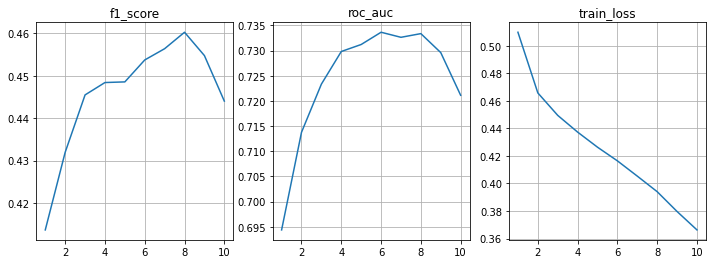

Mean loss=0.366


In [33]:
metrics = {'train_loss': [], 'roc_auc': [], 'f1_score': []}
n_epochs = 10

for epoch in range(1, n_epochs+1):
    avg_loss = 0.0
    for index, batch in enumerate(tqdm(train_dataloader)):
        context, phrase, y = batch
        context = list(context)
        phrase = list(phrase)
        #context_tokens = main_tokenizer(context, padding=True, truncation='only_first',
        #                                return_tensors="pt").to(device)
        phrase_tokens = main_tokenizer(phrase, padding=True, truncation='only_first',
                                       return_tensors="pt").to(device)
        proba = phrase_model(phrase_tokens)

        del phrase_tokens
        loss_t = loss(input=proba, target=y)

        opt.zero_grad()
        loss_t.backward()
        opt.step()

        avg_loss += loss_t.item()

    avg_loss /= index
    metrics['train_loss'].append((epoch, avg_loss))

    if True: #epoch % 5 == 0:
        full_proba, full_y = inference_on_texts(main_tokenizer, phrase_model, test_dataloader)
        
        metrics['roc_auc'].append((epoch, roc_auc_score(full_y, full_proba)))
        metrics['f1_score'].append((epoch, f1_score(full_y, full_proba > 0.15)))

        clear_output(True)
        plt.figure(figsize=(12,4))
        for i, (name, history) in enumerate(sorted(metrics.items())):
            plt.subplot(1, len(metrics), i + 1)
            plt.title(name)
            plt.plot(*zip(*history))
            plt.grid()
        plt.show()
        print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-1:], axis=0)[1], flush=True)